# Infiltrationsbestimmung nach Green und Ampt

Mit Green-Ampt-Modell lässt sich die kumulative Infiltration $ I(t)$ in den Boden als Funktion der Zeit $t$ beschreiben:.

$$ I(t) - \Delta\theta \Delta h \ln \left( 1 + \frac{I(t)}{\Delta h} \right) = K_s t $$

$$t = \frac{I(t) - \Delta\theta \Delta h \ln \left(1 + \frac{I(t)}{\Delta\theta \Delta h} \right)}{K_s}$$

wobei: $t$...Zeit [min], $i(t)$...kummulative Infiltration, $\Delta\theta$...Differenz zwischen dem initialen und durchfeuchteten Bodenwassergehalt, $\Delta h$...Differenz zwischen dem initialen und finalen Matrixpotenzial, sowie $K_s$...gesättigte hydraulische Leitfähigkeit des Bodens.

In [ ]:
from PIL import Image

GreenAmpt_jpg = Image.open('GreenAmptImage.jpg')
GreenAmptjpg_resize = GreenAmpt_jpg.resize((400,300))
display(GreenAmptjpg_resize)


### Werte für verschiedene Bodenparameter

| Korngrößen | Gesättigte hydraulische <br> Leitfähigkeit Ks [mm/h] | Matrixpotential an der <br> Feuchtefront [mm] | Porosität [-] | Feldkapazität [-] | Welkepunkt [-] |
|------------|:--------------------------------------:|:-----------------:|:-------------:|:-------------:|:----------:|
| Sand | 120 | -49 bis -150 | 0,437 | 0,062 | 0,024 |
| lehmiger Sand | 30 | -61 bis -250 | 0,437 | 0,105 | 0,047 |
| sandiger Lehm | 11 | -110 bis -250 | 0,453 | 0,190 | 0,085 |
| Lehm | 3 | -89 bis -350 | 0,463 | 0,232 | 0,116 |
| Schluffiger Lehm | 7 | -170 | 0,501 | 0,284 | 0,135 |
| sandig-toniger Lehm | 2 | -220 | 0,398 | 0,244 | 0,136 |
| toniger Lehm | 1 | -210 | 0,464 | 0,310 | 0,187 |
| schluffig-toniger Lehm | 1 | -270 | 0,471 | 0,342 | 0,210 |
| sandiger Ton | 1 | -240 | 0,430 | 0,321 | 0,221 |
| schluffiger Ton | 1 | -290 | 0,479 | 0,371 | 0,251 |
| Ton | 0,3 | -320 bis -1000 | 0,475 | 0,378 | 0,265 |

nach: D.A. Chin: Water-Resources Enginieering (2013)


In [112]:
# Instalation der verwendeten Bibliotheken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact,interactive, fixed, interact_manual, Button, Layout
from IPython.display import clear_output


# Zur Eingabe 
....

In [113]:


class GreenAmptModel:                                                                   # Klasse mit Methoden zur Berechnung und Visualisierung der Infiltration nach Green-Ampt (1911)

    def __init__(self):
        '''
        Initalisierung
        '''             
        self.reference_lines = []                                                                       # Initialisierung von Parametern bzw. Listen, in denen später berechnete
        self.ref_line_params = []                                                                       # Werte gespeichert werden können.
        self.short_time_ref = []                                                                        # Durch die Initialisierung sind die mit "self" markierten Variablen für alle
        self.short_time_params = []                                                                     # Methoden in der Klasse: GreenAmptModel sichtbar.
        self.infiltration_rate_ref = []
        self.infiltration_ref = []
        self.i_data = []
        self.ti_data=[]
        self.I_data=[]
        self.tI_data=[]


    def t_for_It(self, I_t, d_theta, d_h, Ks):                                                    
        '''
        Methode zur Berechnung der Zeitabstände zwischen den einzelnen Infiltrationsschritten
        Parameter:
            self...Referenz auf das zugehörige Objekt
            I_t...np.array: mit Infiltrationswerten
            d_theta...Float: Differenz zwischen dem Wassergehalt vor und nach der Infiltration
            d_h...Float: Differenz zwischen Matrixpotential an Feuchtefront und Wasseroberfläche
            Ks...Float: gesättigte hydraulische Leitfähigkeit
        Ausgabe:
            np.array
        '''
        return (I_t - d_theta * d_h * np.log(1+ (I_t/(d_theta*d_h))))/Ks                                    

    def long_time_approximation(self, K, x):                                                          
        '''
        Methode zur Bestimmung einer Langzeitnäherung an die Infiltrationsrate
        Parameter:
            K...Float: hydraulische Durchlässigkeit
            x...np.array: x-Werte
        Ausgabe:
            Float
        '''
        it_long = np.array([K]*len(x))                                                                  
        return it_long

    def d_h(self, h0, hf):  
        '''
        Methode zum Ermittel der Differenz zwischen h0 und hf
        Prameter:
            h0...Float: Potential an der Wasseroberfläche
            hf...Float: Matrixpotential an der Feuchtefront
        Ausgabe:
            Float
        '''                                                                    
        return abs(hf-h0)                                                                                        

    def d_theta(self, theta_0, theta_i):
        '''
        Methode zum Ermittel der Differenz zwischen theta_0 und theta_i
        Parameter:
            theta_0...Float: Wassergehalt vor der Infiltration
            theta_i...Float: Wassergehalt nach der Infiltration
        Ausgabe:
            Float
        '''       
        return abs(theta_0-theta_i)
    
    def infiltration_rate(self, new_t, t, I_t):
        '''
        Methode zur Berechnung der Infiltratinsrate
        Parameter:
            new_t...np.array: Zeitschritte von t[0] bis t[-1]
            t...np.array: Zeitschritte siehe t_for_It()
            I_t...np.array: Infiltrationsdaten
        Ausgabe: np.array: Infiltrationsrate
        '''                                                        
        y2 = np.interp(new_t, t, I_t)                                                                          
        i_t = np.diff(y2)
        return i_t
    
    def read_datastring(self, y_data_string='', x_data_string=''):
        '''
        Methode zum Umwandeln von Strings in Listen
        Parameter:
            y_data_string, x_data_string...String: Messdaten im 'Textformat'
        Ausgabe:
            y_data, x_data...List: Messdaten als Listen
        '''
                                              
        if y_data_string and x_data_string != '':                                                   
            y_list = y_data_string.split(',')                              
            x_list = x_data_string.split(',')
            x_data = [eval(i) for i in x_list]
            y_data = [eval(i) for i in y_list]  
            return y_data, x_data


    def plot_scenario(self, I_data_string='', tI_data_string='', i_data_string='', ti_data_string='',   # Methode zum Plotten der Daten
                       hf_h0 = (-600,0), thetai_theta0 = (0.2,0.44), Ks=0.1):

        hf = hf_h0[0]                                                                                   # Vom Benutzer eingelesene Werte werden in Variablen gespeichert
        h0 = hf_h0[1]
        theta_i = thetai_theta0[0]
        theta_0 = thetai_theta0[1]
        Ks = Ks
        
                                                                                                        # Aus den definierten Methoden werden Daten generiert
        delta_theta = self.d_theta(theta_0, theta_i)                                                        # delta theta (type: Float)
        delta_h = self.d_h(h0, hf)                                                                          # delta h (type: Int)
        I_t = np.arange(0.1, 1000, 0.1)                                                                      # Infiltrationsdaten (type: np.array)
        t = self.t_for_It(I_t, delta_theta, delta_h, Ks)                                                    # Zeitschritte für die Infiltration (type: np.array)
        self.new_t = np.arange(round(t[0], 1), round(t[-1], 1), 0.01)                                       # Zeitschritte für die Infiltration auf 1. Dezimalstelle gerundet (type: np.array)
        self.i_t = self.infiltration_rate(self.new_t, t, I_t)                                               # Infiltrationsrate (type: np.array)
        i_t_long = self.long_time_approximation(Ks, self.new_t)                                             # Langzeitannäherung der Infiltrationsrate ~ Ks (type: np.array)


        self.fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))                                              # Eine Abbildung für die Plots wird erstellt


        for ref, params in zip(self.infiltration_ref, self.ref_line_params):                            # In on_button_click() definierte Referenzlinien für I_t werden geplottet
            ref_x, ref_y = ref
            ax1.plot(ref_x, ref_y, linestyle='-.', alpha=0.6, 
                     label='I(t): hf:{}, h0:{}, theta_i:{}, theta_0:{}, Ks:{}'.format(params[0], params[1], params[2], params[3], params[4]), linewidth=2.5)
        
        for ref, params in zip(self.infiltration_rate_ref, self.ref_line_params):                       # In on_button_click() definierte Referenzlinien für I_t werden geplottet
            ref_x, ref_y = ref
            ax2.plot(ref_x, ref_y, linestyle='-.', alpha=0.6,
                      label='i(t): hf:{} h0:{} theta_i:{} theta_0:{} Ks:{}'.format(params[0], params[1], params[2], params[3], params[4]), linewidth=2.5)


        ax1.plot(t, I_t, color='black', 
                 label='I(t): hf:{}, h0:{}, theta_i:{}, theta_0:{}, Ks:{}'.format(hf, h0, theta_i, theta_0, Ks), linewidth=1)                                      # Plotten der Infiltrationsdaten auf einer Achse 
        
        ax1.set_title(label='Green-Ampt Infiltrationsmodell', fontsize=20, loc= 'center')                       # Grenzen für die x- und y-Achse festlegen
        ax1.set_xlim(0, 185)
        ax1.set_xlabel('Zeit [min]', fontsize=10)                                                               # Achsenbeschreibung hinzufügen
        ax1.set_ylabel('Kummulative Infiltration [mm/min]', fontsize=10)
        ax1.grid(which = "major", linewidth = 1)                                                                # Gitternetz hinzufügen
        ax1.grid(which = "minor", linewidth = 0.2)
        ax1.minorticks_on()
        ax1.legend(loc='best')                                                                                  # Legende einblenden


        ax2.plot(self.new_t[1:-5], self.i_t[0:-5]*100, color='black',
                  label='i(t): hf:{}, h0:{}, theta_i:{}, theta_0:{}, Ks:{}'.format(hf, h0, theta_i, theta_0, Ks), linewidth=1)        # Plotten der Infiltrationsrate auf einer weiteren Achse
        ax2.plot(self.new_t, i_t_long, 'red', linestyle='--',                                           # Plotten der Langzeitnäherung auf derselben Achse
                  label='Long time approximation ~ Ks [mm/min]')
                                                                                   # Grenzen für die x- und y-Achse festlegen
        ax2.set_xlim(0, 185)
        ax2.set_yscale('log')                                                                                   # y-Achsenskalierung logarithmisch setzen
        ax2.set_xlabel('Zeit [min]', fontsize=10)                                                               # Achsenbeschreibung hinzufügen
        ax2.set_ylabel('Infiltrationsrate [mm/min]', fontsize=10)
        ax2.grid(which = "major", linewidth = 1)                                                                # Gitternetz hinzufügen
        ax2.grid(which = "minor", linewidth = 0.2)
        ax2.minorticks_on()
        ax2.legend(loc='best')                                                                                  # Legende einblenden

                                                                                                       # Plotten von zusätzlichen, vom Benutzer eingegebenen Messdaten
                                                                                                        ## für die Infiltration
        if I_data_string and tI_data_string != '':                                                               # Wurden Messdaten übergeben? Wenn, ja:
            self.I_data, self.tI_data = self.read_datastring(I_data_string, tI_data_string)                                # Umwandeln von str -> list
            if len(self.I_data) == len(self.tI_data):                       
                ax1.scatter(self.tI_data, self.I_data, color='black', linestyle='', marker='x')                            # Plotten

        if i_data_string and ti_data_string != '':                                                               # Wurden Messdaten übergeben? Wenn, ja:
            self.i_data, self.ti_data = self.read_datastring(i_data_string, ti_data_string)                                # Umwandeln von str -> list
            if len(self.i_data) == len(self.ti_data): 
                ax2.scatter(self.ti_data, self.i_data, color='black', linestyle='', marker='x')                            # Plotten

       
    def on_button_click(self, button):
  
        hf_val = self.hf_h0.value[0]                                                                    # Speichern der über "Widgets" eingelesenen Werte in Variablen
        h0_val = self.hf_h0.value[1]
        theta_i_val = self.thetai_theta0.value[0]
        theta_0_val = self.thetai_theta0.value[1]
        Ks_val = self.Ks_slider.value

        delta_theta = (self.d_theta(theta_0_val, theta_i_val))                                          # Berechnen der Werte mittels oben definierter Methoden
        delta_h = self.d_h(h0_val, hf_val)
        I_t = np.arange(0, 1000, 0.1)
        t = self.t_for_It(I_t, delta_theta, delta_h, Ks_val)
        self.new_t = np.arange(round(t[0], 1), round(t[-1], 1), 0.01)
        i_t = self.infiltration_rate(self.new_t, t, I_t)
  
        self.reference_lines.append((t, I_t))                                                           # Speichern der gerade vom Benutzer eingestellten Funktionsverläufe als np.arrays
        self.ref_line_params.append((h0_val, hf_val, theta_0_val, theta_i_val, Ks_val))                 # ebenfalls für die Parameter
        self.reference_lines.append((self.new_t, i_t))
        self.ref_line_params.append((h0_val, hf_val, theta_0_val, theta_i_val, Ks_val))
        self.infiltration_ref.append((t, I_t))
        self.infiltration_rate_ref.append((self.new_t[1:-5], self.i_t[:-5]*100))

        clear_output(wait=True)                                                                         # Alten Plot löschen und neuen inklusive Referenzlinien Plotten
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)
    

    def on_sfbutton_click(self, sf_button):
        self.fig.savefig('Green_Ampt_Infiltration.png')

        clear_output(wait=True)
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)                                                                         # Alten Plot löschen und neuen inklusive Referenzlinien Plotten
        

    def on_sdbutton_click(self, sd_button):                                                            # Übergibt einen Wahrheitswert, wenn der Button gedrückt ist
        data = {'Kummulative Infiltration [mm]': self.I_data,
                    'Zeit für kummulative Infiltration [min]': self.tI_data,
                    'Infiltrationsrate [mm/min]': self.i_data,
                    'Zeit für Infiltrationsrate [min]': self.ti_data
                    }
        df = pd.DataFrame(data)
        df.to_excel('Infiltrationsdaten.xlsx', index=False)
        print("Die Daten wurden erfolgreich in die Datei 'Infiltrationsdaten.xlsx' geschrieben.")

        clear_output(wait=True)                                                                         # Alten Plot löschen und neuen inklusive Referenzlinien Plotten
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)                                                                 
    

    def create_interactive_plot(self):
        
        self.button = Button(description="Referenzlinie Speichern",                                                      # Erstellen eines Buttons zum Speichern der Referenzlinien
                         layout=Layout(width='20%', height='40px'), button_style='info')
        self.button.on_click(self.on_button_click)                                                                               # Funktion für den Fall des 'gedrückten buttons'

        
        self.sf_button = Button(description="Abbildung Speichern",                                                  #Button zum Speichern der Abbildung
                                layout=Layout(width='20%', height='40px'), button_style='info')                                            
        self.sf_button.on_click(self.on_sfbutton_click)
        

        self.sd_button = Button(description="Messwerte Speichern",                                                  #Button zum Speichern der Abbildung
                                layout=Layout(width='20%', height='40px'), button_style='info')                                                  
        self.sd_button.on_click(self.on_sdbutton_click)
        

    
        self.hf_h0 = widgets.IntRangeSlider(                                                            # Ein IntRangeSlider zum Einlesen von hf und h0 über den Benutzer(übergibt 2 Werte als tuple)
            value=[-600, 0], min=-1000, max=500, step=1,
            description=('hf - h0 [mm]'),style = {'description_width': 'initial'}
            )
        self.thetai_theta0 = widgets.FloatRangeSlider(                                                  # Ein FloatRangeSlider für theta i und theta 0
            value=[0.1, 0.4], min=0, max=0.5, step=0.01,
            description=('theta i - theta 0 [-]'), style = {'description_width': 'initial'}
            )
        self.Ks_slider = widgets.FloatLogSlider(                                                           # Ein FloatSlider für hf und h0 (übergibt einen Float)
            value=0.1, base = 10, min=-3, max=0.7, step=0.01,
            description='Ks [mm/min]' , style = {'description_width': 'initial'}
            )

    

        self.I_data_string = widgets.Textarea(                                                          # 4 Textfelder zum Einlesen von Messdaten (übergibt jeweils einen String)
            placeholder='Daten Bitte mit . als Dezimaltrennzeichen und , als Trennzeichen eingeben',
            description='Kummulative Infiltration I [mm]', style = {'description_width': 'initial'}
            )
        
        self.tI_data_string = widgets.Textarea(
            placeholder='Daten Bitte mit . als Dezimaltrennzeichen und , als Trennzeichen eingeben',
              description='Zeitdaten für I [min]', style = {'description_width': 'initial'}
              )

        self.i_data_string = widgets.Textarea(
            placeholder='Daten Bitte mit . als Dezimaltrennzeichen und , als Trennzeichen eingeben',
              description='Infiltrationsate i [mm/min]', style = {'description_width': 'initial'}
              )
        
        self.ti_data_string = widgets.Textarea(
            placeholder='Daten Bitte mit . als Dezimaltrennzeichen und , als Trennzeichen eingeben',
              description='Zeitdaten für i [min]', style = {'description_width': 'initial'}
              )



        self.interactive_plot = interactive(                                                             # Verknüpfen der interaktiven Eingabewidgets mit dem Plot
            self.plot_scenario, 
            I_data_string=self.I_data_string, tI_data_string=self.tI_data_string, 
            i_data_string=self.i_data_string, ti_data_string=self.ti_data_string, 
            hf_h0 = self.hf_h0, thetai_theta0 = self.thetai_theta0, Ks=self.Ks_slider
            )
        


        clear_output(wait=True)
        display(self.interactive_plot)
        display(self.button)
        display(self.sf_button)
        display(self.sd_button)                                                                   # Aufruf von Plot und Button        


     



0, 3.2, 5.2, 7.5, 9.5, 11.7, 13.5, 15.5, 17.3, 19.4, 21.2, 23.6, 25.3, 27.1, 28.6, 30.2
tI: 0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75
i:  0, 3.2, 2, 2.3, 2, 2.2, 1.8, 2, 1.8, 2.1, 1.8, 2.4, 1.7, 1.8, 1.5, 1.6
ti: 

# Eingabe


interactive(children=(Textarea(value='', description='Kummulative Infiltration I [mm]', placeholder='Daten Bit…

Button(button_style='info', description='Referenzlinie Speichern', layout=Layout(height='40px', width='20%'), …

Button(button_style='info', description='Abbildung Speichern', layout=Layout(height='40px', width='20%'), styl…

Button(button_style='info', description='Messwerte Speichern', layout=Layout(height='40px', width='20%'), styl…

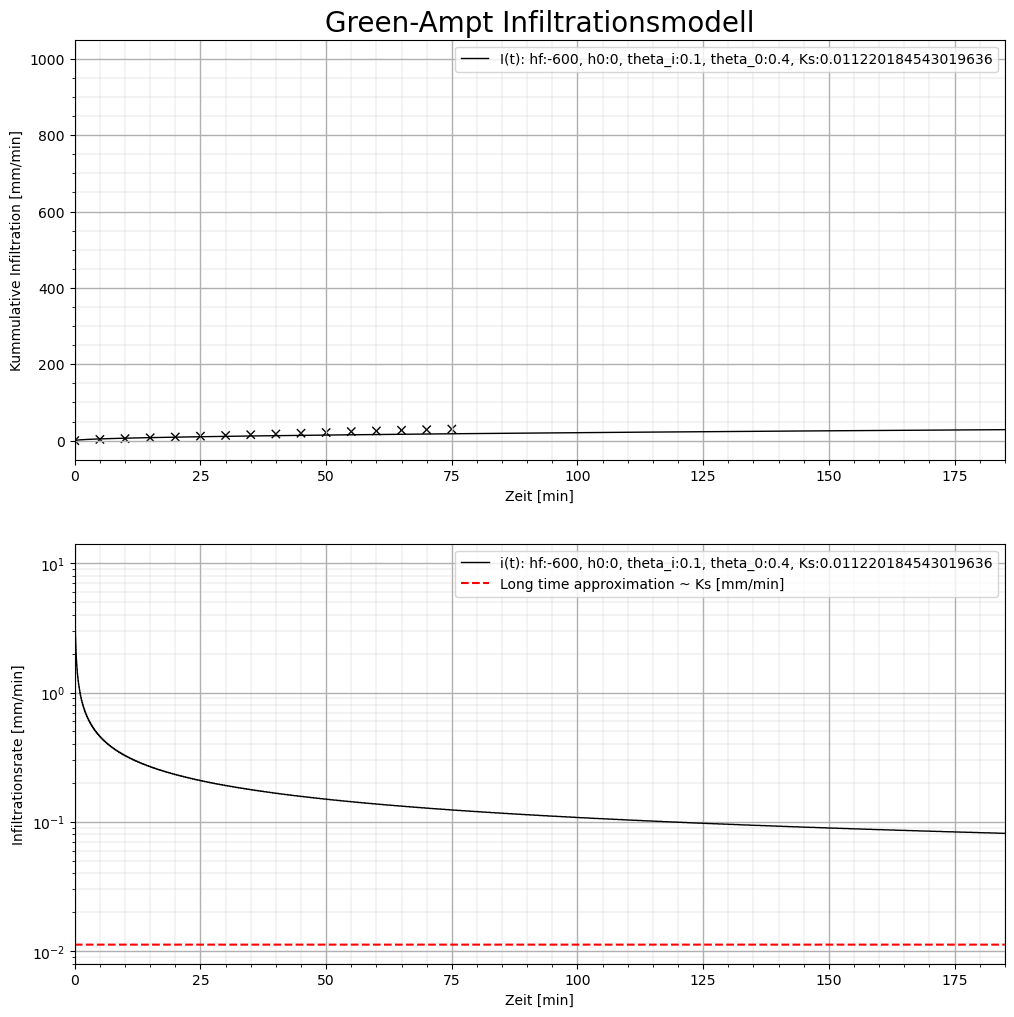

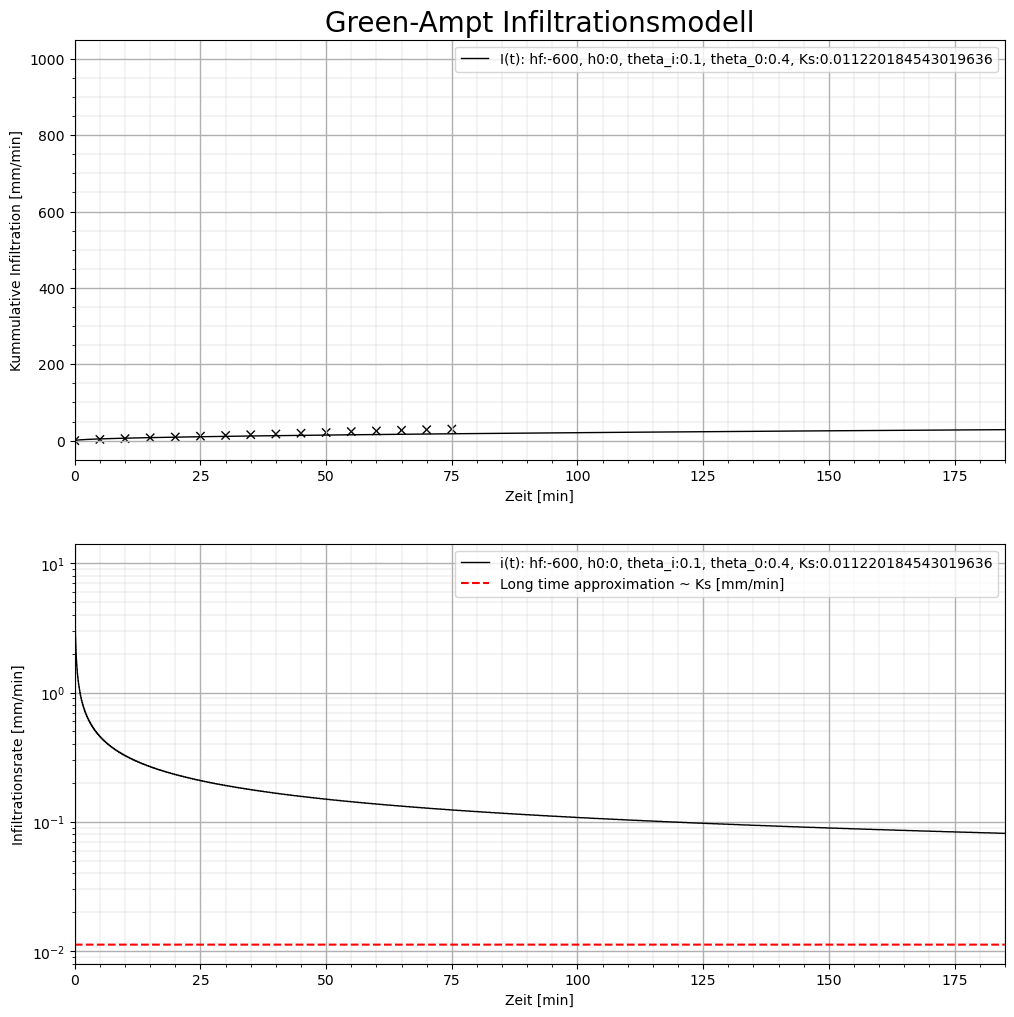

In [114]:
GreenAmptModel().create_interactive_plot()
